Things to Try

- Avoid overfitting, use high min_child weight
- Remove cases where sum of all lag is zero
- Use mean item price across all stores and use that to compute price delta
- Get lags for shop aggregates, item aggegates, category aggregates
- reduce lags to 1,2,3,6,12

### Relevant links

https://www.kaggle.com/c/competitive-data-science-predict-future-sales


Also in this notebook, I am trying to change how features are generated in the v0 version, Here I will not fix the training month to only one month but rather use all data points and take lags. Will take out of time sample as a validation dataset but training will have data from any number of months

### Imports

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 33.3 ms


In [79]:
from toolbox import *
from scripts.future_sales_prediction_custom import *

time: 24.2 ms


In [40]:
from scripts.imports import *
import scripts.kaggle_data as kd

time: 33.4 ms


In [15]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', 999)
pd.options.mode.chained_assignment = None

time: 29.7 ms


### Getting data

In [ ]:
current_path = os.getcwd()
data_dir_path = os.path.join(current_path,"data")

if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

print(data_dir_path) #Never print

In [ ]:
kd.download_data('competitive-data-science-predict-future-sales',current_path)

In [9]:
#Listify files to download
all_data_files = os.listdir('data/') #Getting all files in data folder in a list
all_data_files = [x for x in all_data_files if x.endswith('.csv')] #Removing .ipynb files
all_data_files = [remove_from_right(x,4) for x in all_data_files] #Removing .csvs
all_data_files

['shops',
 'items',
 'item_categories',
 'sales_train',
 'sample_submission',
 'test']

time: 4.96 ms


In [10]:
for i in all_data_files:
    print(i + "=" + f"kd.read_data('data/','csv','{i}')")
    print("")
    exec(i + "=" + f"kd.read_data('data/','csv','{i}')")
    exec(f"shape = {i}.shape")
    print(f"Shape of {i}: ", shape)
    exec(f"data_types = {i}.dtypes")
    print("")
    print(f"Data types in {i}: \n \n ", data_types)
    print("---------------------")

shops=kd.read_data('data/','csv','shops')

Shape of shops:  (60, 2)

Data types in shops: 
 
  shop_name    object
shop_id       int64
dtype: object
---------------------
items=kd.read_data('data/','csv','items')

Shape of items:  (22170, 3)

Data types in items: 
 
  item_name           object
item_id              int64
item_category_id     int64
dtype: object
---------------------
item_categories=kd.read_data('data/','csv','item_categories')

Shape of item_categories:  (84, 2)

Data types in item_categories: 
 
  item_category_name    object
item_category_id       int64
dtype: object
---------------------
sales_train=kd.read_data('data/','csv','sales_train')

Shape of sales_train:  (2935849, 6)

Data types in sales_train: 
 
  date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object
---------------------
sample_submission=kd.read_data('data/','csv','sample_submission')

Sh

In [11]:
save_test = test

time: 932 µs


### Testing data

#### Structural checks

In [ ]:
#Unique data values
#sales_train >> \
#select(X.date,X.date_block_num) >> \
#distinct(X.date,X.date_block_num) >> \
#arrange(X.date_block_num, ascending = True) 

#Finding
#We have daily sales data as well

In [ ]:
#Check for missing value in train data
#for k in sales_train.columns:
    #display_all(sales_train >> summarise_each([null_percent],k))

#### See headers of all data

In [ ]:
sales_train >> head

In [ ]:
shops >> head

In [ ]:
items >> head

In [ ]:
item_categories >> head

In [ ]:
test >> head

### Feature engineering

#### Create features

In [16]:
# Add dates to training data
sales_train = add_datepart(df = sales_train, custom_date_format = '%d.%m.%Y',field_name = 'date', drop = False)
#Assignment is done to avoid printing the dataframe
raw_data = sales_train

time: 4.55 s


In [17]:
#Convert item_id and shop_id as strings
#Replace negative values of sales with 0 and add separate field for capturing returns
raw_data = raw_data >> mutate(item_id = X.item_id.astype(str), shop_id = X.shop_id.astype(str)) >> \
mutate(item_cnt_day = if_else(X.item_cnt_day < 0, 0, X.item_cnt_day),
      item_cnt_day_return = if_else(X.item_cnt_day < 0, -X.item_cnt_day,0))

time: 10.1 s


In [18]:
#raw_data >> select(X.date_block_num,X.Month,X.Year) >> \
#distinct(X.date_block_num,X.Month,X.Year) >> arrange(X.date_block_num)
#Will use date block num as a unique month idetifier from now on

time: 23.5 ms


In [23]:
#Compute monthly metrics
#Price changes 
#number of purchases
#Translate everything daily to monthly
#Standard deviation is a time consuming computation in dask, so not including for now

metric_dictionary = {'item_cnt_day': ['sum','count'],'item_price' : ['mean']}

raw_data_month = dd_summarise(raw_data,['item_id','shop_id','date_block_num'],metric_dictionary)
raw_data_month = raw_data_month >> mutate(per_day_sales = X.item_cnt_day_sum/X.item_cnt_day_count)

time: 4.74 s


In [24]:
#Cap sales value from 0 to 20
raw_data_month = raw_data_month >> mutate(item_cnt_day_sum = if_else(X.item_cnt_day_sum > 20, 20, X.item_cnt_day_sum))

time: 853 ms


In [25]:
#Unique values in each field
all_items = raw_data >> select(X.item_id) >> distinct(X.item_id)
print("All items: ", all_items.shape)
all_shops = raw_data >> select(X.shop_id) >> distinct(X.shop_id)
print("All shops: ", all_shops.shape)
all_months = raw_data >> select(X.date_block_num) >> distinct(X.date_block_num)
print("All months: ", all_months.shape)
item_shop = raw_data >> select(X.item_id,X.shop_id) >> distinct(X.item_id,X.shop_id)
print("All item-shop combination: ", item_shop.shape)
item_shop_from_test = save_test >> \
mutate(item_id = X.item_id.astype(str), shop_id = X.shop_id.astype(str)) >> \
select(X.item_id,X.shop_id) >> distinct(X.item_id,X.shop_id)
print("All item-shop combination from test: ", item_shop_from_test.shape)
item_shop_all = item_shop >> bind_rows(item_shop_from_test) >> \
select(X.item_id,X.shop_id) >> distinct(X.item_id,X.shop_id)
print("All item-shop combination from train + test: ", item_shop_all.shape)

All items:  (21807, 1)
All shops:  (60, 1)
All months:  (34, 1)
All item-shop combination:  (424124, 2)
All item-shop combination from test:  (214200, 2)
All item-shop combination from train + test:  (526920, 2)
time: 4.31 s


In [107]:
#Train and valid
item_shop_all_merge = item_shop_all >> mutate(key = 1)
all_months = all_months >> mask(X.date_block_num > 8) >> mutate(key = 1) #Keeping 2 Novembers
sparse_raw_data_month = item_shop_all_merge >> inner_join(all_months, by = ['key']) >> drop(X.key) >> \
left_join(raw_data_month, by = ['item_id','shop_id','date_block_num'])

sparse_raw_data_month.item_cnt_day_sum.fillna(0,inplace = True) 
sparse_raw_data_month.item_cnt_day_count.fillna(0,inplace = True)
sparse_raw_data_month.fillna(-999,inplace = True) #For price and sales per day


print("Shape of sparse data: ", sparse_raw_data_month.shape )

#Test
test = save_test >> mutate(item_id = X.item_id.astype(str), 
                           shop_id = X.shop_id.astype(str), 
                           date_block_num = 34) >> drop(X.ID) >> sample(100)

print("Shape of test data: ", test.shape )

Shape of sparse data:  (13173000, 7)
Shape of test data:  (100, 3)
time: 16.9 s


In [108]:
#Select training and valid months
#Training: Past November: 22   and October: 21 , take other months as well
#Since capturing all months will isolate nature of trips in November
#Valid: Current October: 33

#Start creating lag variables for everything and then merge with test data to attach the features

samples = item_shop_all >> sample(100) 
sparse_raw_data_month_sample = sparse_raw_data_month >> inner_join(samples, by = ['item_id','shop_id']) 

metric_list = ['item_cnt_day_sum','item_price_mean']
sparse_raw_data_month_sample = apply_lag(sparse_raw_data_month_sample,
                                         ['item_id','shop_id'],
                                         'date_block_num', 
                                         metric_list,
                                         [1,2,3,4,5,6,11,12,13])


print('Shape before NaN removal: ',sparse_raw_data_month_sample.shape )
sparse_raw_data_month_sample.dropna(inplace = True)
print('Shape after NaN removal: ',sparse_raw_data_month_sample.shape )

#Get the same metrics for test data
sparse_raw_data_month_test = test >> select(X.item_id,X.shop_id) >> \
inner_join(sparse_raw_data_month, by = ['item_id','shop_id']) 

concatenated_test = pd.concat([test, sparse_raw_data_month_test], sort=True) >> arrange(X.item_id,X.shop_id,X.date_block_num)

test = apply_lag(concatenated_test,
                 ['item_id','shop_id'],
                 'date_block_num', 
                 metric_list,
                 [1,2,3,4,5,6,11,12,13])

test = test >> mask(X.date_block_num == 34) 

test.item_cnt_day_sum.fillna(0,inplace = True) 
test.item_cnt_day_count.fillna(0,inplace = True) 
test.item_price_mean.fillna(-999,inplace = True) 
test.per_day_sales.fillna(-999,inplace = True) 

print('Shape before NaN removal: ',test.shape )
test.dropna(inplace = True)
print('Shape after NaN removal: ',test.shape ) #There shouldn't be any drop

#Fill price -999 with NAs again so that mean computation in future steps are correct
test.replace(-999,np.NaN,inplace = True)
sparse_raw_data_month_sample.replace(-999,np.NaN,inplace = True)

lag: 1 done
lag: 2 done
lag: 3 done
lag: 4 done
lag: 5 done
lag: 6 done
lag: 11 done
lag: 12 done
lag: 13 done
Metric: item_cnt_day_sum done
lag: 1 done
lag: 2 done
lag: 3 done
lag: 4 done
lag: 5 done
lag: 6 done
lag: 11 done
lag: 12 done
lag: 13 done
Metric: item_price_mean done
Shape before NaN removal:  (2500, 25)
Shape after NaN removal:  (1200, 25)
lag: 1 done
lag: 2 done
lag: 3 done
lag: 4 done
lag: 5 done
lag: 6 done
lag: 11 done
lag: 12 done
lag: 13 done
Metric: item_cnt_day_sum done
lag: 1 done
lag: 2 done
lag: 3 done
lag: 4 done
lag: 5 done
lag: 6 done
lag: 11 done
lag: 12 done
lag: 13 done
Metric: item_price_mean done
Shape before NaN removal:  (100, 25)
Shape after NaN removal:  (100, 25)
time: 6.16 s


In [110]:
#Get date features for all date block num
date_block_num_mapping = dd_summarise(raw_data,['date_block_num'],{'Month':['min']})
sparse_raw_data_month_sample = sparse_raw_data_month_sample >> left_join(date_block_num_mapping, by = ['date_block_num'])
test = test >> mutate(Month_min = 11)

time: 1.15 s


In [111]:
#Item category size 
sparse_raw_data_month_sample = item_category_size(sparse_raw_data_month_sample,items)
test = item_category_size(test,items)

time: 309 ms


In [112]:
#Parameters for next set of features
custom_parameters = {
 'sum_values': None,
 'skewness': None,
 'linear_trend': [{"attr": "slope"}]}

metric_list_sales = ['item_cnt_day_sum_lag_1',
                     'item_cnt_day_sum_lag_2',
                     'item_cnt_day_sum_lag_3',
                     'item_cnt_day_sum_lag_4',
                     'item_cnt_day_sum_lag_5',
                     'item_cnt_day_sum_lag_6']

metric_list_sales_more = ['item_cnt_day_sum_lag_1',
                     'item_cnt_day_sum_lag_2',
                     'item_cnt_day_sum_lag_3',
                     'item_cnt_day_sum_lag_4',
                     'item_cnt_day_sum_lag_5',
                     'item_cnt_day_sum_lag_6',
                     'item_cnt_day_sum_lag_11',
                     'item_cnt_day_sum_lag_12',
                     'item_cnt_day_sum_lag_13']

metric_list_price = ['item_price_mean_lag_1',
                     'item_price_mean_lag_2',
                     'item_price_mean_lag_3',
                     'item_price_mean_lag_4',
                     'item_price_mean_lag_5',
                     'item_price_mean_lag_6']

level_1 = ['item_id','shop_id','date_block_num']
level_2 = ['item_id','date_block_num']
level_3 = ['shop_id','date_block_num']
level_4 = ['item_category_id','date_block_num']

time: 21.2 ms


In [113]:
#Add 6M item presence
sparse_raw_data_month_sample = item_presence(sparse_raw_data_month_sample,metric_list_sales) 
test = item_presence(test,metric_list_sales) 

time: 447 ms


In [114]:
#Create new features from the lag features

sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        ,level_1
                                        ,metric_list_sales
                                        ,custom_parameters
                                        ,'sum'
                                        ,'config'
                                        ,'month' )

sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        ,level_2
                                        ,metric_list_sales
                                        ,custom_parameters
                                        ,'sum'
                                        ,'item'
                                        ,'month')

sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        ,level_3
                                        ,metric_list_sales
                                        ,custom_parameters
                                        ,'sum'
                                        ,'shop'
                                        ,'month' )

sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        ,level_4
                                        ,metric_list_sales
                                        ,custom_parameters
                                        ,'sum'
                                        ,'category'
                                        ,'month' )

sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        ,level_2
                                        ,metric_list_sales_more
                                        ,None
                                        ,'sum'
                                        ,'item'
                                        ,'month'
                                        , drop_lag_fields = False)

sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        ,level_3
                                        ,metric_list_sales_more
                                        ,None
                                        ,'sum'
                                        ,'shop'
                                        ,'month'
                                        , drop_lag_fields = False)

sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        ,level_4
                                        ,metric_list_sales_more
                                        ,None
                                        ,'sum'
                                        ,'category'
                                        ,'month'
                                        , drop_lag_fields = False)

sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        ,level_2
                                        , metric_list_price
                                        , None
                                        , 'mean'
                                        ,'item'
                                        ,'month'
                                        ,drop_lag_fields = False)


sparse_raw_data_month_sample = apply_ts(sparse_raw_data_month_sample
                                        , level_1
                                        , metric_list_price
                                        , None
                                        ,'mean'
                                        ,'config'
                                        ,'month'
                                        ,drop_lag_fields = False)

Feature Extraction: 100%|██████████| 65/65 [00:00<00:00, 1131.62it/s]


time: 17.4 s


In [115]:
#Create new features from the lag features

test = apply_ts(test,level_1,metric_list_sales,custom_parameters,'sum','config','month' )
test = apply_ts(test,level_2,metric_list_sales,custom_parameters,'sum','item','month' )
test = apply_ts(test,level_3,metric_list_sales,custom_parameters,'sum','shop','month' )
test = apply_ts(test,level_4,metric_list_sales,custom_parameters,'sum','category','month' )

test = apply_ts(test, level_2,metric_list_sales_more,None,'sum','item','month',drop_lag_fields = False)
test = apply_ts(test, level_3,metric_list_sales_more,None,'sum','shop','month',drop_lag_fields = False)
test = apply_ts(test, level_4,metric_list_sales_more,None,'sum','category','month',drop_lag_fields = False)

test = apply_ts(test, level_2,metric_list_price,None,'mean','item','month',drop_lag_fields = False)
test = apply_ts(test, level_1,metric_list_price,None,'mean','config','month',drop_lag_fields = False)

Feature Extraction: 100%|██████████| 29/29 [00:00<00:00, 27029.96it/s]


time: 15.2 s


In [117]:
#Add ratio of item_price vs item store price
sparse_raw_data_month_sample = sparse_raw_data_month_sample >> \
mutate(price_ratio_lag_1 = X.item_item_price_mean_lag_1 / X.config_item_price_mean_lag_1,
        price_ratio_lag_2 = X.item_item_price_mean_lag_2 / X.config_item_price_mean_lag_2,
        price_ratio_lag_3 = X.item_item_price_mean_lag_3 / X.config_item_price_mean_lag_3,
        price_ratio_lag_4 = X.item_item_price_mean_lag_4 / X.config_item_price_mean_lag_4,
        price_ratio_lag_5 = X.item_item_price_mean_lag_5 / X.config_item_price_mean_lag_5,
        price_ratio_lag_6 = X.item_item_price_mean_lag_6 / X.config_item_price_mean_lag_6)
       
test = test >> \
mutate(price_ratio_lag_1 = X.item_item_price_mean_lag_1 / X.config_item_price_mean_lag_1,
        price_ratio_lag_2 = X.item_item_price_mean_lag_2 / X.config_item_price_mean_lag_2,
        price_ratio_lag_3 = X.item_item_price_mean_lag_3 / X.config_item_price_mean_lag_3,
        price_ratio_lag_4 = X.item_item_price_mean_lag_4 / X.config_item_price_mean_lag_4,
        price_ratio_lag_5 = X.item_item_price_mean_lag_5 / X.config_item_price_mean_lag_5,
        price_ratio_lag_6 = X.item_item_price_mean_lag_6 / X.config_item_price_mean_lag_6)

time: 35.1 ms


In [119]:
#Treat NaNs again for price fields
sparse_raw_data_month_sample.fillna(-999,inplace = True)
test.fillna(-999,inplace = True)

time: 28 ms


In [120]:
#Remove instances where aggregate sales in past N months is zero for items

print(sparse_raw_data_month_sample.shape)
sparse_raw_data_month = sparse_raw_data_month_sample >> \
mask((X.item_item_cnt_day_sum_lag_1 + 
      X.item_item_cnt_day_sum_lag_2 + 
      X.item_item_cnt_day_sum_lag_3 + 
      X.item_item_cnt_day_sum_lag_4 + 
      X.item_item_cnt_day_sum_lag_5 + 
      X.item_item_cnt_day_sum_lag_6 + 
      X.item_item_cnt_day_sum_lag_11 + 
      X.item_item_cnt_day_sum_lag_12 + 
      X.item_item_cnt_day_sum_lag_13) > 0)
print(sparse_raw_data_month.shape)

print(test.shape)
test = test >> \
mask((X.item_item_cnt_day_sum_lag_1 + 
      X.item_item_cnt_day_sum_lag_2 + 
      X.item_item_cnt_day_sum_lag_3 + 
      X.item_item_cnt_day_sum_lag_4 + 
      X.item_item_cnt_day_sum_lag_5 + 
      X.item_item_cnt_day_sum_lag_6 + 
      X.item_item_cnt_day_sum_lag_11 + 
      X.item_item_cnt_day_sum_lag_12 + 
      X.item_item_cnt_day_sum_lag_13) > 0)  
print(test.shape)

(1200, 86)
(412, 86)
(100, 86)
(45, 86)
time: 242 ms


In [121]:
#Drop all price columns which has NULLs
metric_list_price_config = ['config_' + x for x in metric_list_price]
print(metric_list_price_config)
sparse_raw_data_month.drop(metric_list_price, axis=1 ,inplace = True)
sparse_raw_data_month.drop(metric_list_price_config, axis=1, inplace = True)
test.drop(metric_list_price, axis=1 ,inplace = True)
test.drop(metric_list_price_config, axis=1, inplace = True)

['config_item_price_mean_lag_1', 'config_item_price_mean_lag_2', 'config_item_price_mean_lag_3', 'config_item_price_mean_lag_4', 'config_item_price_mean_lag_5', 'config_item_price_mean_lag_6']
time: 35.2 ms


In [122]:
#Now generate train, valid and test DFs

#test = test
train = sparse_raw_data_month >> mask(X.date_block_num != 33)
valid = sparse_raw_data_month >> mask(X.date_block_num == 33)

time: 38.1 ms


In [90]:
#Pickle them for later use
sparse_raw_data_month_sample.to_pickle('data/train_valid.pkl')
test.to_pickle('data/test.pkl')

time: 1min 20s


### EDA

#### Check distribution

In [ ]:
check = dd_summarise(raw_data,['date_block_num','item_id','shop_id'],'item_cnt_day','sum')

In [ ]:
check[check.item_cnt_day > 20].shape[0]/check.shape[0]

In [ ]:
sns.distplot(check.item_cnt_day[check.item_cnt_day>0])

### Modelling

#### Xgboost

In [91]:
##data preparation
ind_columns = train.columns.to_list()

list_to_remove = ['shop_id','item_id','item_cnt_day_sum','date_block_num','item_price_mean','per_day_sales','item_cnt_day_count']
ind_columns = remove_elements(ind_columns, list_to_remove )

dep_coloumns = ["item_cnt_day_sum"]

cont_vars = train.head(5).select_dtypes(include= [np.number]).columns.to_list()
cont_vars = remove_elements(cont_vars, ['item_cnt_day_sum','date_block_num','item_price_mean','per_day_sales','item_cnt_day_count'])

cat_vars = train.head(5).select_dtypes(include= [object]).columns.to_list()
list_to_remove = ['shop_id','item_id']

cat_vars = remove_elements(cat_vars, list_to_remove)


x_train = train[ind_columns]
y_train = train[dep_coloumns]

x_test = test[ind_columns]

x_valid = valid[ind_columns]
y_valid = valid[dep_coloumns]

print("Shape of training data: ", x_train.shape)
print("Shape of validation data: ", x_valid.shape)
print("Shape of test data: ", x_test.shape)

xg_train = xgb.DMatrix(x_train, label = y_train)
xg_test = xgb.DMatrix(x_test)
xg_valid = xgb.DMatrix(x_valid, label = y_valid)

Shape of training data:  (4215360, 42)
Shape of validation data:  (526920, 42)
Shape of test data:  (214200, 42)
time: 6.48 s


In [92]:
#Model
param = {'max_depth':8,
         'eta':0.05, # learning rate
         'gamma':2,
         'min_child_weight':10,
         'objective':'reg:squarederror',
         'eval_metric': 'rmse' ,
         'colsample_bytree': 0.6}

watchlist  = [(xg_valid, 'valid')]
num_round = 1000

xgm = xgb.train(param, xg_train, num_round, evals = watchlist, early_stopping_rounds=10)

[07:47:33] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	valid-rmse:0.845905
Will train until valid-rmse hasn't improved in 10 rounds.
[1]	valid-rmse:0.82836
[2]	valid-rmse:0.812946
[3]	valid-rmse:0.798648
[4]	valid-rmse:0.78599
[5]	valid-rmse:0.774116
[6]	valid-rmse:0.763633
[7]	valid-rmse:0.753819
[8]	valid-rmse:0.744997
[9]	valid-rmse:0.737224
[10]	valid-rmse:0.729391
[11]	valid-rmse:0.72264
[12]	valid-rmse:0.716399
[13]	valid-rmse:0.711044
[14]	valid-rmse:0.705974
[15]	valid-rmse:0.701267
[16]	valid-rmse:0.696802
[17]	valid-rmse:0.693138
[18]	valid-rmse:0.689798
[19]	valid-rmse:0.686842
[20]	valid-rmse:0.684203
[21]	valid-rmse:0.681953
[22]	valid-rmse:0.679828
[23]	valid-rmse:0.678115
[24]	valid-rmse:0.67664
[25]	valid-rmse:0.675306
[26]	valid-rmse:0.674077
[27]	valid-rmse:0.673206
[28]	valid-rmse:0.672307
[29]	valid-rmse:0

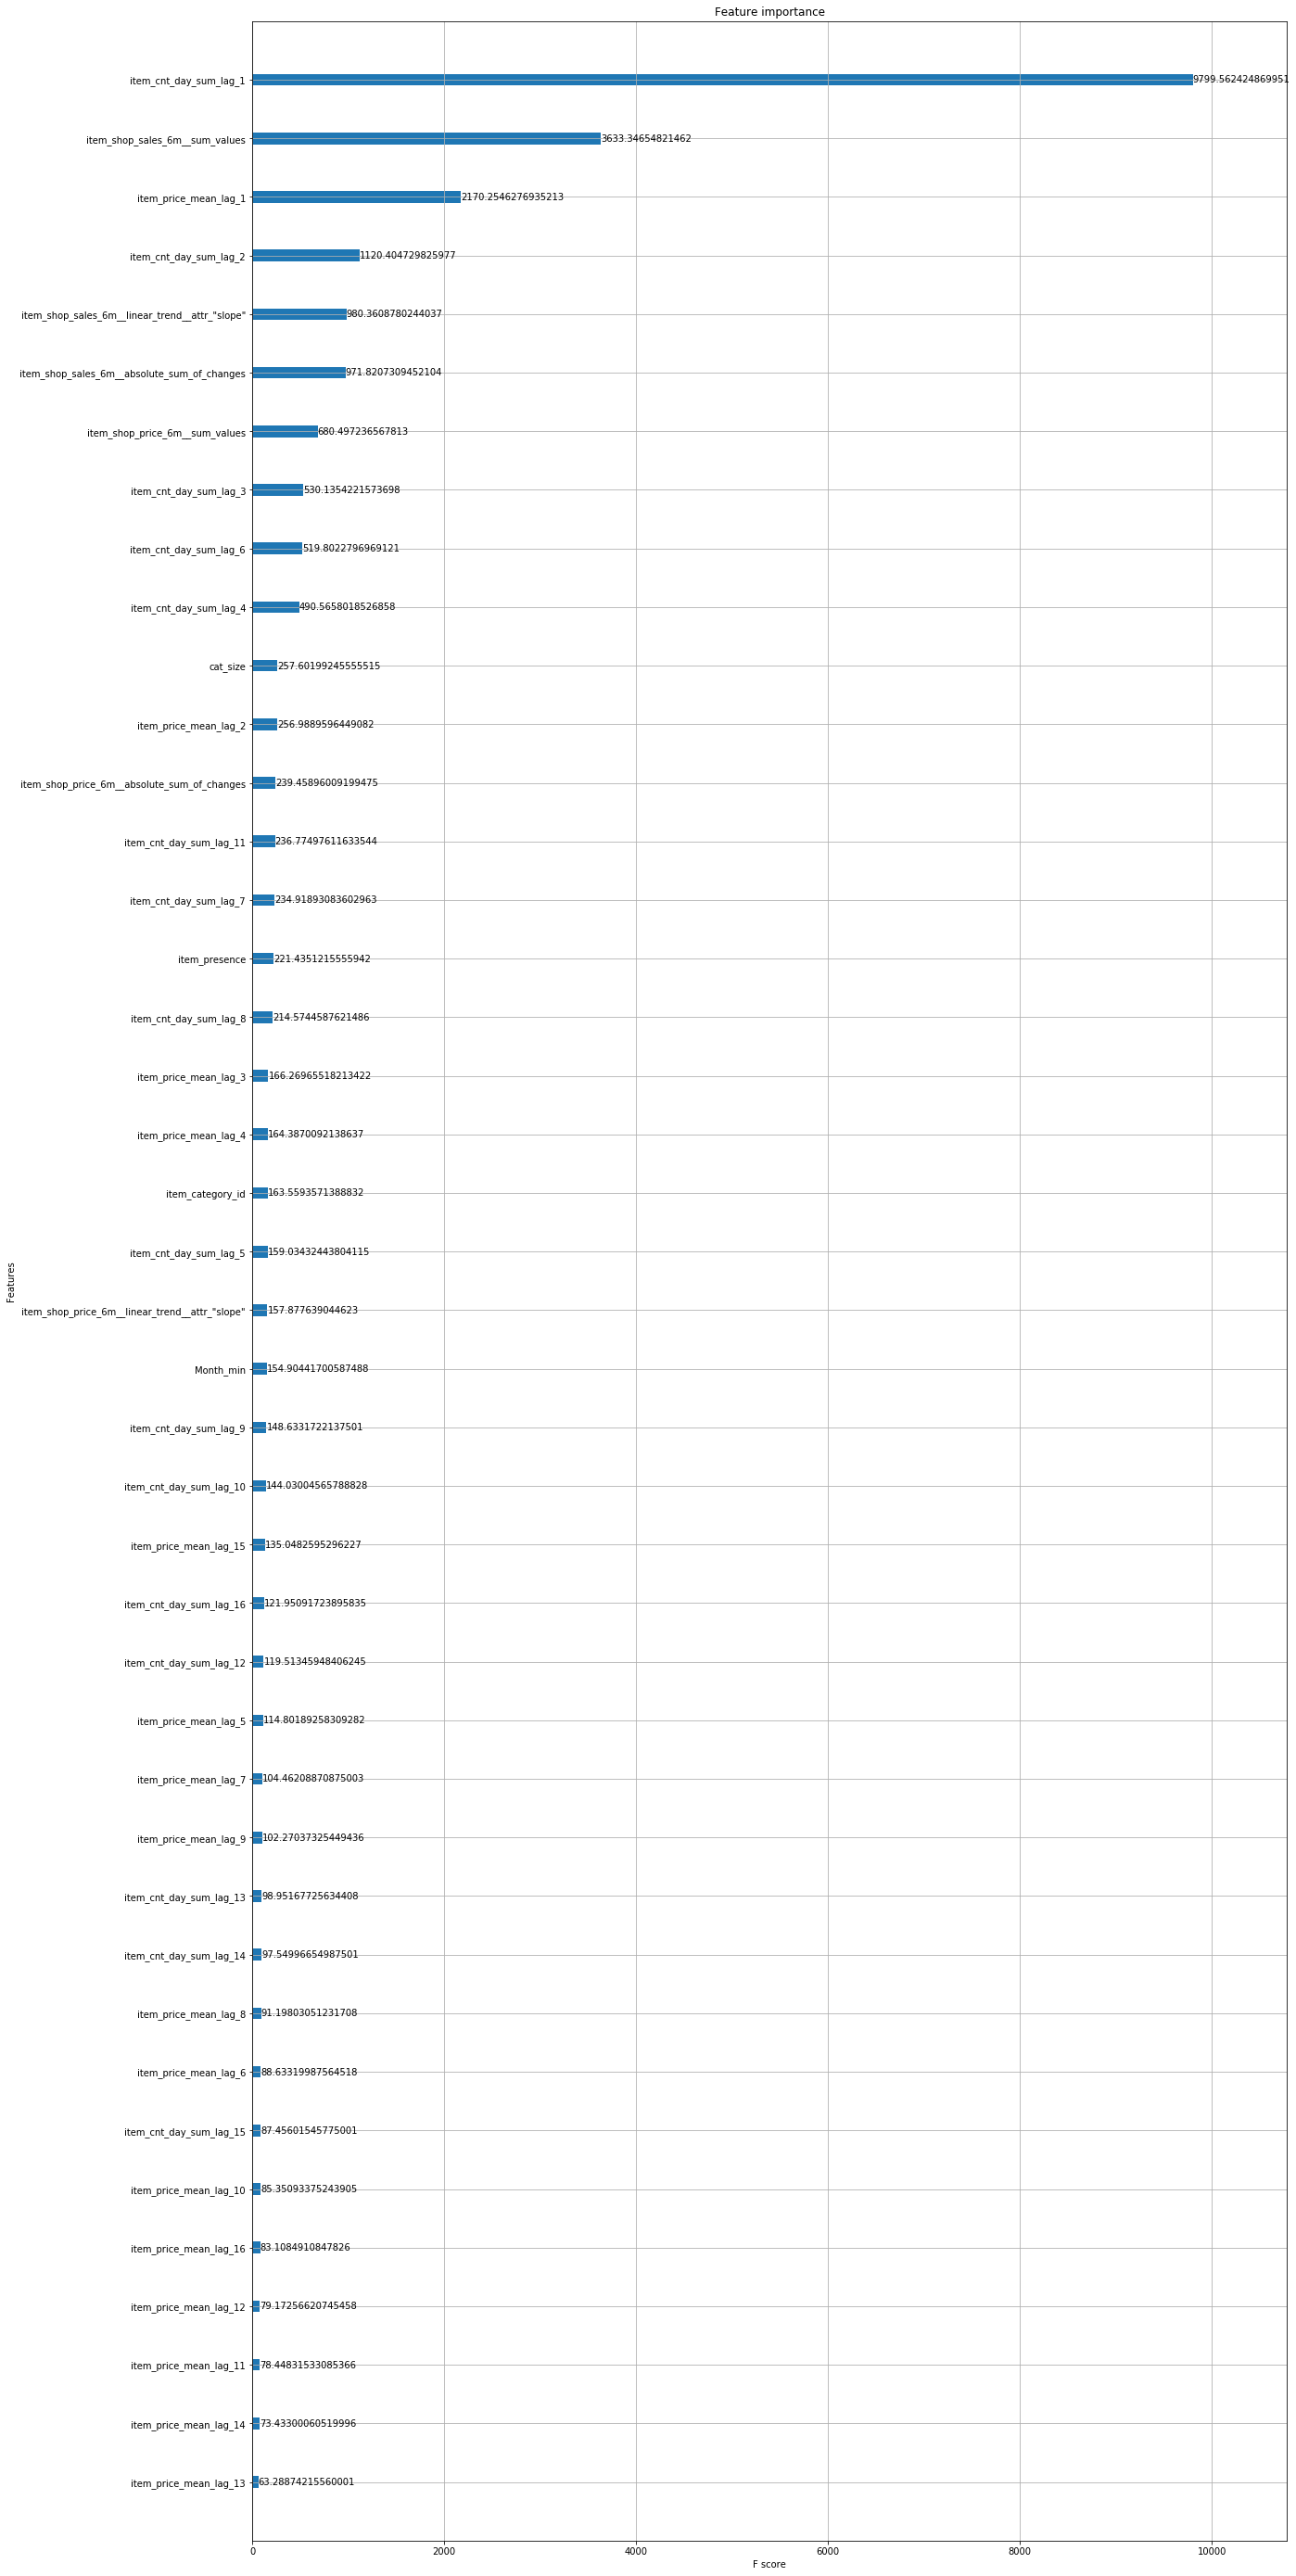

time: 2.39 s


In [93]:
my_plot_importance(xgm,(20,50),importance_type='gain')

In [94]:
#RMSE in validation data
rmse(xgm.predict(xg_valid),y_valid.values.ravel())

0.6698230819469949

time: 35.2 ms


In [95]:
#RMSE in train data
rmse(xgm.predict(xg_train),y_train.values.ravel())

0.5648185193252857

time: 85.8 ms


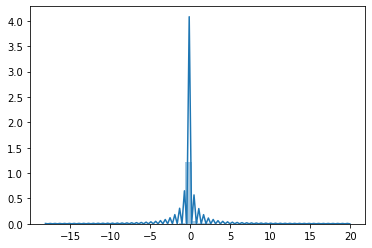

time: 1.32 s


In [96]:
valid_predictions = xgm.predict(xg_valid)
valid_predictions = valid >> mutate(item_cnt_day_predicted = valid_predictions) >> \
mutate(errors = (X.item_cnt_day_sum - X.item_cnt_day_predicted))

vp = valid_predictions

sns.distplot(vp.item_cnt_day_sum - vp.item_cnt_day_predicted)

### Submission

#### XGBoost

In [97]:
test_predictions = xgm.predict(xg_test)
test_predictions.shape

(214200,)

time: 227 ms


In [98]:
test_submission = save_test >> mutate(item_cnt_month = test_predictions) >> drop(X.item_id,X.shop_id)

time: 32.9 ms


In [99]:
test_submission.to_csv('data/submission__xgb_v6.csv', index=False)

time: 1.85 s


### Unit tests